# Bimodal Distribution

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.polynomial.polynomial import polyfit

from scipy.stats import pearsonr, norm
from scipy.special import erf
from scipy.optimize import newton
from scipy.interpolate import PPoly

from statsmodels.distributions.copula.api import GaussianCopula

In [52]:
sns.set(rc={'figure.figsize':(5.7, 5.7/1.618)})

## Bimodal Normal

In [45]:
def binormal_cdf(x, mu, sigma, alpha):
    res = 0.25 * (2 + 
                  erf((x-mu-alpha*sigma)/(sigma*np.sqrt(2))) + 
                  erf((x-mu+alpha*sigma)/(sigma*np.sqrt(2))))
    return res

def binormal_pdf(x, mu, sigma, alpha):
    res = 1/(np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * ((x-mu)/sigma)**2 - alpha**2/2) * np.cosh(alpha*(x-mu)/sigma)
    return res

def eval_poly(x, coef_arr):
    res = 0
    deg = 0
    for c in coef_arr:
        res += c * (x ** deg)
        deg += 1
    return res

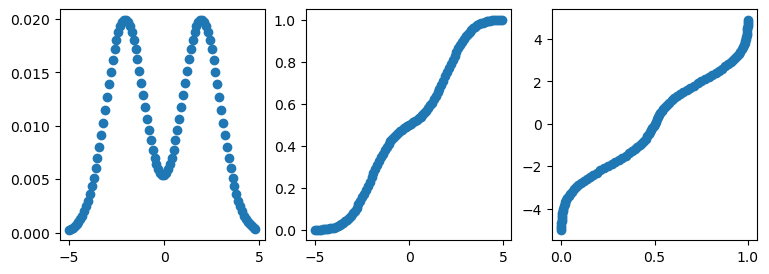

In [46]:
mu = 0
sigma = 1
alpha = 2
#sigma = 1 / np.sqrt(1 + alpha**2)
arr_x = np.arange(-5, 5, 0.1)
arr_cdf = binormal_cdf(arr_x, mu, sigma, alpha)
arr_pdf = np.diff(arr_cdf)

plt.figure(figsize=(9,3))
plt.subplot(1, 3, 1)
plt.scatter(arr_x[:99], arr_pdf)
plt.subplot(1, 3, 2)
plt.scatter(arr_x, arr_cdf)
plt.subplot(1, 3, 3)
plt.scatter(arr_cdf, arr_x)

In [47]:
# Fit polynomial onto points
coef_arr = polyfit(arr_cdf, arr_x, 17)

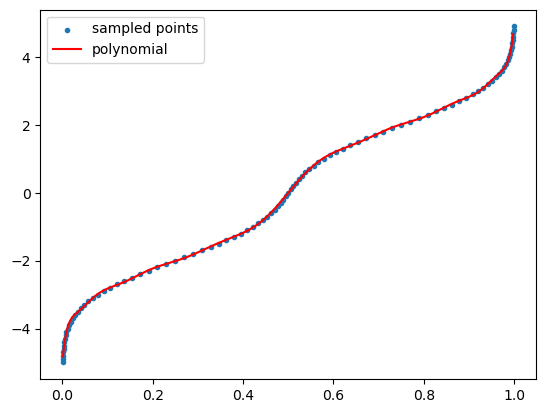

In [48]:
temp = np.arange(0.001, 0.999, 0.001)
arr_ppf_exact = eval_poly(temp, coef_arr)

plt.figure()
plt.scatter(arr_cdf, arr_x, label='sampled points', marker='.')
plt.plot(temp, arr_ppf_exact, label='polynomial', color='red')
plt.legend()

C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


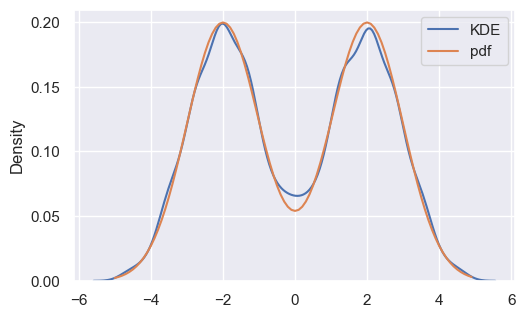

In [53]:
sample_bn_numerical = np.zeros(50000)
for i in range(50000):
    x = np.random.uniform(0.001, 0.999)
    sample_bn_numerical[i] = eval_poly(x, coef_arr)

#plt.hist(sample_bn_numerical, bins=50)
sns.kdeplot(sample_bn_numerical, label='KDE')

# Reference
arr_pdf_analytic = binormal_pdf(arr_x, mu, sigma, alpha)
plt.plot(arr_x, arr_pdf_analytic, label='pdf')
plt.legend()
plt.savefig("gen_bimodal_pdf_kde.png", dpi=300)

C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


PearsonRResult(statistic=0.0007551725285347768, pvalue=0.9809716289327719)


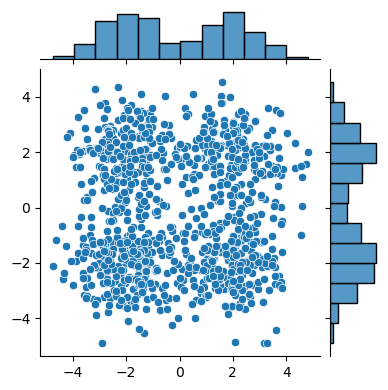

In [50]:
# Sample from Gaussian copula
res = GaussianCopula(corr=0.0).rvs(1000)
arr_uniform_1 = res[:,0]
arr_uniform_2 = res[:,1]

# Sample form first
sample_bn_numerical_1 = np.zeros(1000)
for i in range(1000):
    x = arr_uniform_1[i]
    sample_bn_numerical_1[i] = eval_poly(x, coef_arr)

# Sample form second
sample_bn_numerical_2 = np.zeros(1000)
for i in range(1000):
    y = arr_uniform_2[i]
    sample_bn_numerical_2[i] = eval_poly(y, coef_arr)

sns.jointplot(x=sample_bn_numerical_1, y=sample_bn_numerical_2, height=4)
print(pearsonr(sample_bn_numerical_1, sample_bn_numerical_2))

## Bivariate BN

In [96]:
def bivariate_bimodal_normal(x, theta, lam, corr_1, corr_2):

    # Assertions regarding dimensions of vectors
    assert x.shape == (2, 1)

    p = 1/np.cosh(lam*theta) * np.exp(-lam*theta) / 2

    cov_matr_1 = np.array([[1, corr_1], [corr_1, 1]])
    cov_matr_2 = np.array([[1, corr_2], [corr_2, 1]])

    under_exp_1 = -0.5 * np.dot(
        np.dot(
            (x + theta).transpose(),
            np.linalg.inv(cov_matr_1)),
        x + theta)
    under_exp_2 = -0.5 * np.dot(
        np.dot(
            (x - theta).transpose(),
            np.linalg.inv(cov_matr_2)),
        x - theta)
    
    first = p / (2 * np.pi * np.sqrt(np.linalg.det(cov_matr_1))) * np.exp(under_exp_1)
    second = (1 - p) / (2 * np.pi * np.sqrt(np.linalg.det(cov_matr_2))) * np.exp(under_exp_2)
    res = first + second
    return res

In [91]:
def standard_bivariate_bimodal_normal(z_1, z_2, rho):
    under_exp = -0.5/(1-pow(rho,2)) * (pow(z_1,2) - 2*rho*z_1*z_2 + pow(z_2,2))
    res = 1 / (2 * np.pi * np.sqrt(1 - pow(rho,2))) * np.exp(under_exp)
    return res

In [92]:
def bivariate_bimodal_normal(x_1, x_2, mu_1, mu_2, sigma_1, sigma_2, alpha, rho):
    z_1 = (x_1-mu_1)/sigma_1
    z_2 = (x_2-mu_2)/sigma_2
    res_1 = np.exp(alpha**2 * (rho**2-2) / 2) / (sigma_1 * sigma_2)
    res_2 = standard_bivariate_bimodal_normal(z_1, z_2, rho)
    res_3 = np.cosh(alpha*z_1 + alpha*(1-rho)*z_2)
    res = res_1 * res_2 * res_3
    return res

In [93]:
bivariate_bimodal_normal(0.5, 0.5, 1.5, -1.5, 1.0, 1.0, 0, 0)

0.013064233284684921

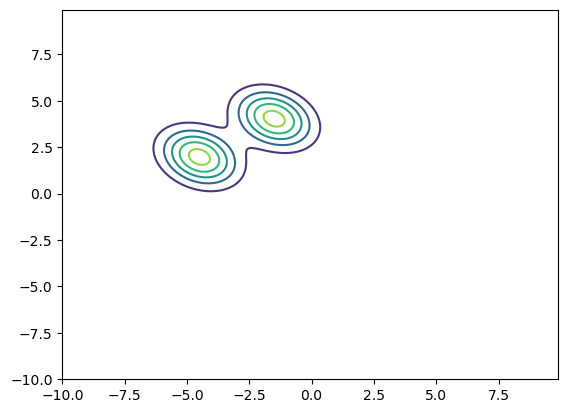

In [94]:
mu_1 = 3.0
mu_2 = -3.0
sigma_1 = 1.0
sigma_2 = 1.0
alpha = 1.5
rho = -0.25

x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
arr = np.zeros(shape=(200, 200))

for i in range(200):
    for j in range(200):
        f = bivariate_bimodal_normal(x[i], y[j], mu_1, mu_2, sigma_1, sigma_2, alpha, rho)
        arr[i][j] = f

plt.contour(x, y, arr)